In [6]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
import sys
sys.path.append('../')

from scripts.cosine_smoothed_mask import cosine_smoothed_mask

In [2]:
nside=256
freqs=np.arange(544,1088,step=1)
nfreqs=len(freqs)

lmax=3*nside -1

In [4]:
smoothed_hi_maps=np.load("smoothed_hi_maps.npy")

In [5]:
def compute_master (maps: np.ndarray, masks:np.ndarray, X:bool, nsides:int, l_max:int, n_freq:int)-> np.ndarray:

    cldec = np.zeros((lmax-1, n_freq, n_freq))
    

    # Loop over all pairs of frequency maps (cross-power spectra)
    for i in range(n_freq):
        print(f"Decoupling map {i}")
        for j in range(i, n_freq):  # Compute only upper triangle (symmetric matrix)

            # Define the masked fields for the two maps
            f_i = nmt.NmtField(1 - masks, [maps[i, :]], masked_on_input=X, lmax=l_max) 
            f_j = nmt.NmtField(1 - masks, [maps[j, :]], masked_on_input=X, lmax=l_max) 
            
            # Define a NaMaster binning scheme (no binning)
            b = nmt.NmtBin.from_nside_linear(nsides, 1)

            cldec[:,i,j] = nmt.compute_full_master(f_i, f_j, b)
            

            # Since Cl is symmetric, copy the value to (j, i)
            if i != j:
                cldec[:, j, i] = cldec[:, i, j]
                
    return cldec

In [43]:
def compute_weights(n_freqs:int, l_max=int, Cl= np.ndarray)-> tuple[np.ndarray, np.ndarray]:

    r"""
    Computes the weights for the covariance matrix.

    \(\omega_i(l) = \frac{\sum_j (C_l^{-1})_{ij} b_{j}}{\sum_{ij}b_i (C_l^{-1})_{ij} b_{j}}\)

    Parameters:
    -------
    n_freqs: int
      Number of frequency channels.
    l_max: int
      Maximum number of multipole lmax.
    Cl: np.ndarray
      Covariance matrix.
    
    Returns:
    -------
      Cl_inv : np.ndarray
        Pseudo inverse of the Cl_matrix.
      
      wi : np.ndarray
        Weights dependent on frequency and multipole of shape (n_freqs x m) 
    """
    #CMB spectral energy density
    b= np.ones(n_freqs, dtype=float ) #array filled with values of 1. column vector

    wi= np.zeros((n_freqs, l_max-1), dtype=float) #weights

    Cl_inv =np.zeros((n_freqs, n_freqs), dtype=float)

    for l in range(l_max-1):

        Cl_matrix =   Cl[l,:,:]/(2*l +1) #cov matrix for a specific l (nfreqs x nfreqs)
        

        Cl_inv[:,:] = np.linalg.pinv(Cl_matrix[:,:]) #(nfreqs x nfreqs)
        numerator = np.dot(Cl_inv,  b) #nfreqs x 1
        b_trans = b.T
        denominator = np.dot(b_trans, np.dot( Cl_inv, b)) #scalar?? 1x1


        for nf in range(n_freqs):
            wi[:, l] = numerator[:]/denominator# (nfreqs x m) Since this is inside l loop it is only the weight for a specific l. looping will give us the correct shape?
            #w[:,l]= np.maximum(w[:,l], 0)  # Force weights to be non-negative
            # wi[:,l] /= np.sum(wi[:,l], axis=0, keepdims=True)  # Normalize to sum to 1
    return Cl_inv, wi

In [44]:
mask=cosine_smoothed_mask(nside)
mask= (mask*(-1))+1

In [45]:
cl_dec= compute_master(smoothed_hi_maps[:10], mask, False, nside, lmax, len(freqs[:10]))

Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4
Decoupling map 5
Decoupling map 6
Decoupling map 7
Decoupling map 8
Decoupling map 9


In [46]:
_, weights = compute_weights(len(freqs[:10]), lmax, cl_dec)

In [47]:
cl_dec.shape

(766, 10, 10)

In [48]:
def mask_maps(map:np.ndarray, masks:np.ndarray, almsize:int, l_max:int, n_freq:int, n_pix:int)->tuple[np.ndarray, np.ndarray]:
    """
    Masks input maps and then converts them to harmonic space.

    Parameters:
    - maps: numpy array of shape (n_freqs, n_maps) containing the frequency maps
    - masks: mask to apply to the maps
    - l_max: maximum multipole for the power spectra
    - n_freq: number of frequency channels
    - n_pix: number of pixels

    Returns:
    - masked: masked pixel space maps
    - almmasked: masked maps converted to harmonic space
    
    """
    masked =np.zeros((n_freq, n_pix))
    almmasked = np.zeros((n_freq, almsize), dtype=complex)
    for nf in range(n_freq):
        masked[nf,:] =map[nf,:]*(1-masks)
        almmasked[nf,:]= hp.map2alm(masked[nf,:], l_max, mmax=None, iter=0, pol=False)
    return masked, almmasked

In [49]:
alm_size=hp.Alm.getsize(lmax)
npix=hp.nside2npix(nside)
masked_maps, alms_masked= mask_maps(smoothed_hi_maps[:10], mask, alm_size,lmax, len(freqs[:10]), npix)

In [50]:
def compute_alm_ilc(almmaps:np.ndarray, alm_size:int, wi:np.ndarray, l_max:int):
    r"""
    Computes the weighted spherical harmonic coefficients.

    \(a^{ILC}_{lm} = \sum_i w_i(l)a^i_{lm}\)

    Parameters:
    -------
    almmaps: np.ndarray
        Sky maps converted from pixel space to harmonic space.
    
    alm_size: int
        Number of spherical harmonic coefficients (lmax+1)^2.

    wi : np.ndarray
        Weights.

    l_max: int
        Maximum multipole.
    
    Returns:
    ------
    almilc : np.ndarray
        Shape of (almsize x 1)
    """

    almilc = np.zeros((alm_size), dtype=complex)

    for l in range(2,l_max +1):
        ell_idx= l-2
        index= np.zeros((l+1), dtype=int)
        for m in range(l+1):
            index[m]= hp.Alm.getidx(l_max, l, m)
        alm_p = almmaps[:, index]

        alm = np.dot(wi[:,ell_idx], alm_p[:,:]) # multiplying (9x384) and (9x1) to get (384x1)=this is for one l (m =0-> l). we iterate over all l
        '''
        #summing over frequencies. and taking ALL m values for a fixed l. Looping over l means 
        so we get an alm weighted by contributions from all frequencies over all scales.
        this should be the same as writing alm_p??
        '''
        almilc[index]= alm #putting alm values back into an array corresponding to their proper positions. flat array
    return almilc

In [51]:
alm_ilc=compute_alm_ilc(alms_masked, alm_size, weights, lmax)

In [52]:
alm_ilc.shape

(295296,)

In [58]:
clean_maps = hp.alm2map(alm_ilc, nside, lmax=lmax, mmax=None)
clean_maps=np.tile(clean_maps, (1, 10))
clean_maps = clean_maps.reshape(10, npix)
print(clean_maps.shape)

(10, 786432)


In [59]:
hilc= compute_master(clean_maps[:10], mask, True, nside, lmax, len(freqs[:10]))

Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4
Decoupling map 5
Decoupling map 6
Decoupling map 7
Decoupling map 8
Decoupling map 9


In [122]:
nfreqs=10

In [131]:
def compute_hilc(map, nside, lmax, nfreqs):
    mask=cosine_smoothed_mask(nside)
    mask= (mask*(-1))+1
    cl_dec= compute_master(map[:nfreqs], mask, False, nside, lmax, len(freqs[:nfreqs]))
    _, weights = compute_weights(nfreqs, lmax, cl_dec)
    alm_size=hp.Alm.getsize(lmax)
    npix=hp.nside2npix(nside)
    masked_maps, alms_masked= mask_maps(map[:nfreqs], mask, alm_size,lmax, nfreqs, npix)
    alm_ilc=compute_alm_ilc(alms_masked, alm_size, weights, lmax)
    clean_maps = hp.alm2map(alm_ilc, nside, lmax=lmax, mmax=None)
    clean_maps=np.tile(clean_maps, (1, nfreqs))
    clean_maps = clean_maps.reshape(nfreqs, npix)
    hilc= compute_master(clean_maps[:nfreqs], mask, True, nside, lmax, nfreqs)
    return hilc

In [133]:
cl_hilc= compute_hilc(smoothed_hi_maps, nside, lmax, nfreqs)

Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4
Decoupling map 5
Decoupling map 6
Decoupling map 7
Decoupling map 8
Decoupling map 9
Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4
Decoupling map 5
Decoupling map 6
Decoupling map 7
Decoupling map 8
Decoupling map 9


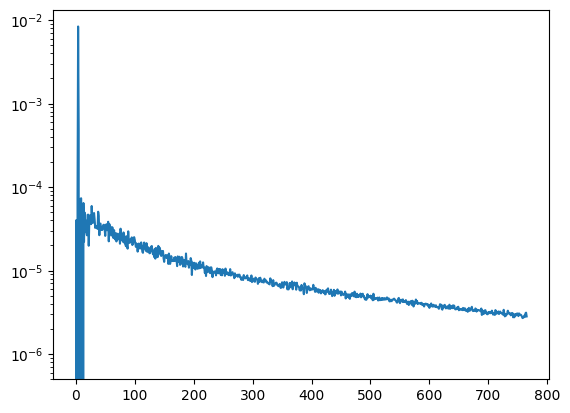

In [134]:
plt.plot(cl_hilc[:,0,0])
plt.yscale("log")

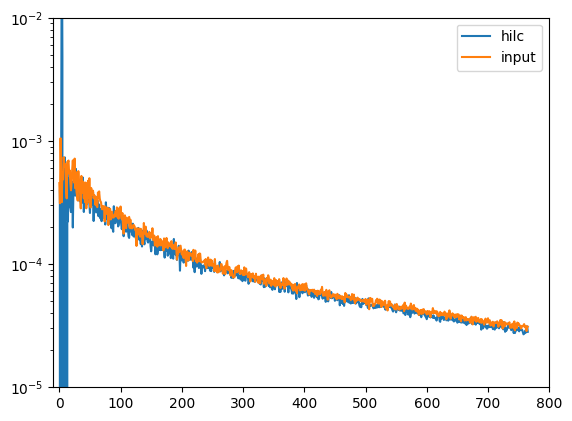

In [138]:
input=hp.anafast(smoothed_hi_maps[0])
plt.plot(hilc[:,0,0]*10, label="hilc")
plt.plot(input[2:], label="input")
# plt.plot(cl_dec[:,0,0], label="cl_dec")
plt.yscale("log")
plt.ylim(1e-5, 1e-2)
plt.xlim(-10, 800)
plt.legend()

(-5.0, 5.0)

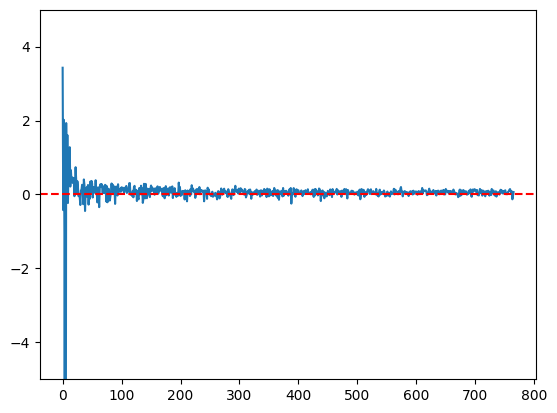

In [119]:
plt.plot((cl_dec[:,0,0]-hilc[:,0,0]*10)/cl_dec[:,0,0])
plt.axhline(0, color='r', linestyle='--')
# plt.xscale("log")
plt.ylim(-5, 5)

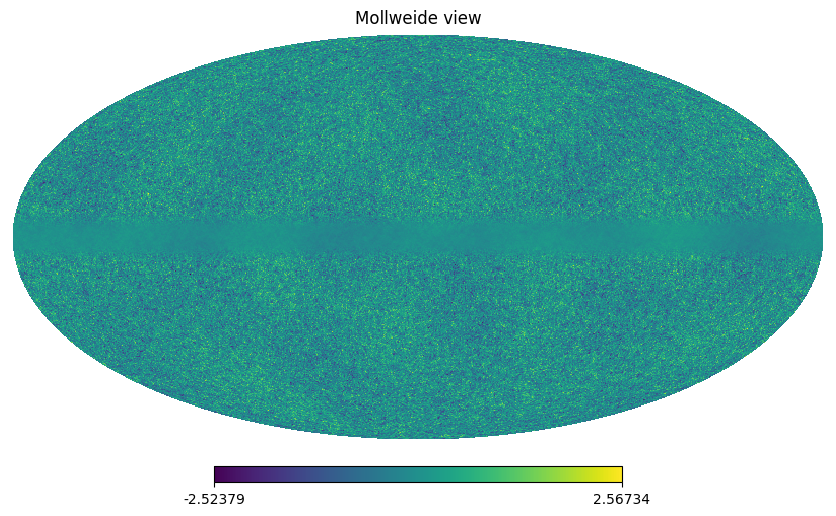

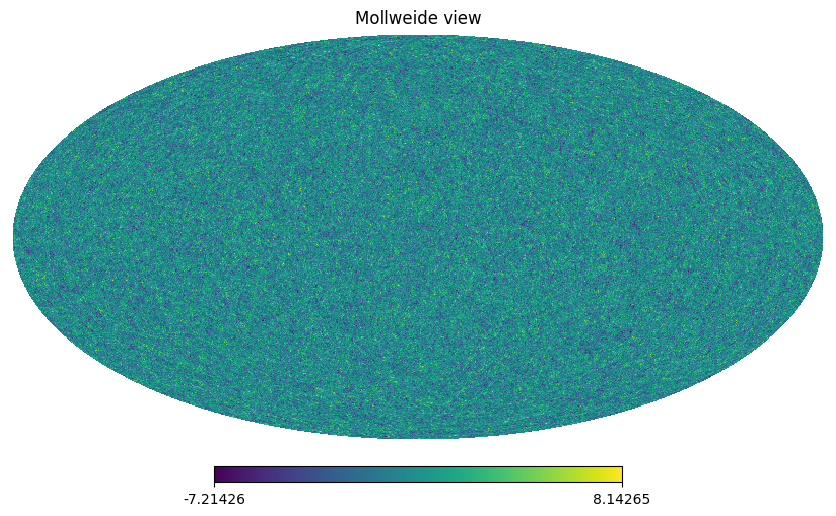

In [57]:
hp.mollview(clean_maps)
hp.mollview(smoothed_hi_maps[0])

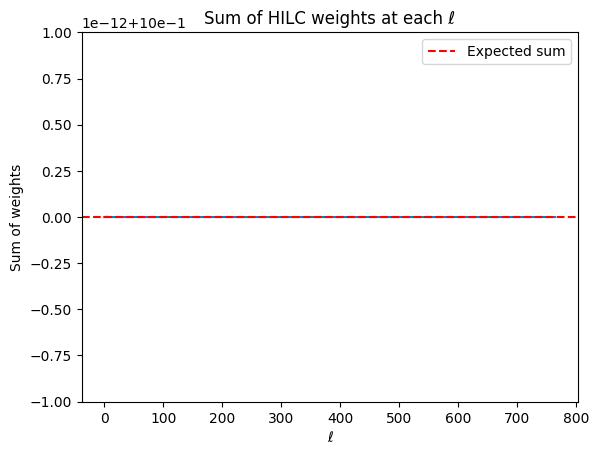

In [82]:
weight_sums = np.sum(weights, axis=0)
plt.plot(weight_sums)
plt.axhline(1.0, color='r', linestyle='--', label='Expected sum')
plt.xlabel('ℓ')
plt.ylabel('Sum of weights')
plt.title('Sum of HILC weights at each ℓ')
plt.legend()
plt.show()